# Applying Autoencoders to DNA Methylation data from TCGA (MLB Lab) ( 390000 -> 256\*23 -> 500 -> 100 -> 256\*23 -> 390000)

In [ ]:
# TCGA_abbr = {
#     "LAML": "leukemia",
#     "ACC" : "adrenocortical",
#     "BLCA": "bladder",
#     "LGG" : "brain",
#     "BRCA": "breast",
#     "CESC": "cervical",
#     "CHOL": "cholangiocarcinoma",
#     "LCML": "Chronic myelogenous leukemia",
#     "COAD": "Colon adenocarcinoma",
#     "CNTL": "Controls",
#     "ESCA": "Esophageal carcinoma",
#     "FPPP": "FFPE pilot phase II",
#     "GBM":  "Glioblastoma multiforme",
#     "HNSC": "Head",
#     "KICH": "Kidney chromophobe",
#     "KIRC": "Kidney renal clear cell carcinoma",
#     "KIRP": "Kidney renal papillary cell carcinoma",
#     "LIHC": "Liver hepatocellular carcinoma",
#     "LUAD": "Lung adenocarcinoma",
#     "LUSC": "Lung squamous cell carcinoma",
#     "DLBC": "Lymphoid neoplasm diffuse large b-cell lymphoma",
#     "MESO": "Mesothelioma",
#     "MISC": "Miscellaneous",
#     "OV" :  "Ovarian serous cystadenocarcinoma",
#     "PAAD": "Pancreatic adenocarcinoma",
#     "PCPG": "Pheochromocytoma and paraganglioma",
#     "PRAD": "Prostate adenocarcinoma",
#     "READ": "Rectum adenocarcinoma",
#     "SARC": "Sarcoma",
#     "SKCM": "Skin cutaneous melanoma",
#     "STAD": "Stomach adenocarcinoma",
#     "TGCT": "Testicular germ cell tumors",
#     "THYM": "Thymoma",
#     "THCA": "Thyroid carcinoma",
#     "UCS" : "Uterine carcinosarcoma",
#     "UCEC": "Uterine corpus endometrial carcinoma",
#     "UVM" : "Uveal melanoma"
#     }


In [ ]:
import os
repo_path = r"Y:\qiu-lab\Bridget\data\meth\methylation_raw"
# ignore_list = ["assemble.py","assemble2.py",assembled.csv]

cancer_paths = []
for directory in os.listdir(repo_path):
    path = os.path.join(repo_path, directory)
    if os.path.isdir(path) and directory!="LOGS":  
        cancer_paths.append(path)
# cancer_paths

In [ ]:
from time import sleep
from random import random
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import pandas as pd
import glob
from time import time

# custom task that will sleep for a variable amount of time
def create_cancer_df(cancer):
    start = time()
    cancer_df_list = []

    #Parse the Metadata file
    cancer_name = cancer.split("\\")[-1] #Separating the cancer name from the entire path
    metadata_file = f"{cancer}\\manifest_me_{cancer_name}.txt"
    metadata = pd.read_csv(metadata_file, sep='\t')
    #The TCGA barcode is towards the tail end of the "Filename" split with "." 
    metadata["tcga_barcode"] = [patient.rstrip("gdc_hg38.txt").split(".")[-1] for patient in metadata["filename"]]
    metadata = metadata[["id","tcga_barcode"]]
    metadata.set_index('id',inplace=True)

    #Going through every patient directory
    for patient_directory in os.listdir(cancer):
        patient_path = os.path.join(cancer, patient_directory)
        if os.path.isdir(patient_path): 
            #Parsing the important counts file inside the directory
            methylation_data_path = f"{patient_path}\\*HumanMethylation450*" #The data file contains the key word
            methylation_data_file =  glob.glob(methylation_data_path) #Finding files that match that pattern
            patient_df = pd.read_csv(methylation_data_file[0], sep='\t',index_col=0) #Taking the first file in the list that matches -> Assuming only one does

            #Retrieving tcga barcode from metadata file
            tcga_barcode = metadata[metadata.index==patient_directory]["tcga_barcode"].tolist()[0]
            patient_df.rename(columns={"Beta_value": tcga_barcode},inplace=True) #Inserting the patient barcode into the data frame
            cancer_df_list.append(patient_df)

    cancer_df = pd.concat(cancer_df_list,axis=1)   
    end = time()
    print(f"Time for cancer: {cancer_name} = {end-start}")
    return cancer_df

pancancer_df_list = []
with ThreadPoolExecutor(8) as executor:
    # execute tasks concurrently and process results in order
    for result in executor.map(create_cancer_df, cancer_paths):
        pancancer_df_list.append(result)
pancaner_df = pd.concat(pancancer_df_list,axis=1)  

In [ ]:
pancaner_df.dropna(how='all',axis=1,inplace=True) #Removing columns with all nan rows
pancaner_df.dropna(how='all',axis=0,inplace=True) #Removing rows with all nan columns
# import pickle
# with open("pancan_methylation.pickle","wb") as pikd:
#     pickle.dump(pancaner_df,pikd)

In [ ]:
# import joblib
# joblib.dump(pancaner_df, 'pancan_methylation.pkl')

In [ ]:
# pancaner_df = pancaner_df.T

In [ ]:
import joblib
pancaner_df = joblib.load('pancan_methylation.pkl')
pancaner_df.shape

In [ ]:
pancaner_df.head()

In [ ]:
# merged_df.to_csv("pancan_methylation.csv.gz", compression="gzip")
# # merged_df_2 = pd.read_csv("pancan_methylation.csv.gz", index_col=0, compression="gzip") 
# # merged_df_2.head()

### 2. Removing all Nan

In [ ]:
# # pan_can_meth_df.replace("NA", np.nan, inplace=True)
# pan_can_meth_df.dropna(how='all',axis=1,inplace=True) #Removing columns with all nan rows
# pan_can_meth_df.dropna(how='all',axis=0,inplace=True) #Removing rows with all nan columns
# start_filling = time()
# pan_can_meth_df.fillna(pan_can_meth_df.mean(), inplace=True)
# end_filling = time()
# print(f"Time: {end_filling - start_filling}")
# print(pan_can_meth_df.shape)

In [1]:
meth_df_path = r"Y:\qiu-lab\Bridget\data\meth\meth_ALLsamp_notnacpgs_raw.pkl"
import joblib
pancaner_df = joblib.load(meth_df_path)
pancaner_df.shape

(9756, 396065)

### 3. Filling nan cells with mean using numpy

In [3]:
## Removing nan
import numpy as np 
import pandas as pd

pancan_numpy = pancaner_df.to_numpy()
print(pancaner_df.isnull().sum().sum())
col_mean = np.nanmean(pancan_numpy, axis=0)
#Find indices that you need to replace
inds = np.where(np.isnan(pancan_numpy))
#Place column means in the indices. Align the arrays using take
pancan_numpy[inds] = np.take(col_mean, inds[1])

pancancer_meth_df = pd.DataFrame(pancan_numpy,columns = pancaner_df.columns, index = pancaner_df.index)
pancancer_meth_df.isnull().sum().sum()

4119767


0

In [6]:
reference_path = r"Y:\qiu-lab\Bridget\data\meth\methylation_raw\methylation_reference.txt"
reference_df = pd.read_csv(reference_path, sep = "\t")
#Remove those rows that don't have a corresponding column in the pancancer dataframe (Maybe they were removed during preprocessing)
pancan_allfeatures = pancaner_df.columns.tolist()
reference_df = reference_df[reference_df["Composite Element REF"].isin(pancan_allfeatures)]
reference_df.shape

(396065, 10)

In [7]:
# Creating a dictionary with all the Chromsomes and their respective Methylation Probes
chr_dict = reference_df.groupby("Chromosome")["Composite Element REF"].apply(list).to_dict()
del chr_dict['*']
del chr_dict['chrY']
chr_dict.keys()

dict_keys(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX'])

In [8]:
pancancer_meth_list = []
for chromsome, feature_list in chr_dict.items():
    print(chromsome)
    print(len(feature_list))
    new_df = pancancer_meth_df[feature_list]
    new_df = new_df.astype('float16')
    print("Done conveting to float16")
    pancancer_meth_list.append(new_df)

chr1
38021
Done conveting to float16
chr10
19783
Done conveting to float16
chr11
23600
Done conveting to float16
chr12
19810
Done conveting to float16
chr13
9745
Done conveting to float16
chr14
12340
Done conveting to float16
chr15
12446
Done conveting to float16
chr16
17962
Done conveting to float16
chr17
23404
Done conveting to float16
chr18
5008
Done conveting to float16
chr19
21049
Done conveting to float16
chr2
28024
Done conveting to float16
chr20
8649
Done conveting to float16
chr21
3225
Done conveting to float16
chr22
6994
Done conveting to float16
chr3
20139
Done conveting to float16
chr4
15927
Done conveting to float16
chr5
19640
Done conveting to float16
chr6
29181
Done conveting to float16
chr7
24026
Done conveting to float16
chr8
16464
Done conveting to float16
chr9
8031
Done conveting to float16
chrX
9706
Done conveting to float16


In [10]:
## Saving the list of chromosome dataframe
import joblib
joblib.dump(pancancer_meth_list, "pancancer_meth_chr_nonna_fillnamean.pkl")

with open ("pancancer_meth_chr_nonna_fillnamean_reference.txt","w+") as outfile:
    outfile.write(str(chr_dict.keys()))

In [19]:
# import pickle
# file_name = "meth_chr_list.pkl"

# with open(file_name, "wb") as open_file:
#     pickle.dump(pancancer_meth_list, open_file)

# Start Here

In [1]:
import joblib
import pandas as pd

meth_df_path =  "pancancer_meth_chr_nonna_fillnamean.pkl"
pancancer_meth_list = joblib.load(meth_df_path)
len(pancancer_meth_list)

23

In [2]:
pancancer_meth_list[0]

,,,,,cg00000165,cg00000363,cg00000957,cg00001349,cg00001364,cg00001446,cg00001583,cg00002593,cg00002646,cg00002719,...,ch.1.976694F,rs11249206,rs213028,rs2804694,rs3818562,rs3936238,rs6426327,rs654498,rs715359,rs877309
patient,sample,sample_type,aliquot,file,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J4,TCGA-OR-A5J4-01A,01A,TCGA-OR-A5J4-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0874f4b8-5743-4b41-9b99-f02186c8b51e\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J4-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.856445,0.713867,0.912109,0.872070,0.914551,0.908691,0.292236,0.395996,0.949707,0.093140,...,0.030136,0.965820,0.016693,0.974609,0.354248,0.973633,0.973145,0.629883,0.977051,0.183594
TCGA-OR-A5KO,TCGA-OR-A5KO-01A,01A,TCGA-OR-A5KO-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0885b557-48ca-4865-b17a-f2e1f6209b81\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5KO-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.901367,0.903320,0.933594,0.911621,0.913086,0.926758,0.814453,0.925781,0.951172,0.030457,...,0.029602,0.970215,0.019669,0.969238,0.968262,0.023422,0.040344,0.869141,0.975098,0.972656
TCGA-OR-A5J9,TCGA-OR-A5J9-01A,01A,TCGA-OR-A5J9-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\09eb5b05-2794-437b-a307-5255f69c4a32\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J9-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.897949,0.318604,0.929199,0.904785,0.915527,0.908203,0.019165,0.893555,0.945312,0.032288,...,0.031891,0.965332,0.472168,0.966797,0.468018,0.106140,0.574707,0.087280,0.533203,0.532227
TCGA-OR-A5K6,TCGA-OR-A5K6-01A,01A,TCGA-OR-A5K6-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\10ee4988-4a8f-4a0e-ae63-cc891c765fba\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5K6-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.170166,0.523926,0.922852,0.878906,0.903320,0.875488,0.293701,0.922852,0.919922,0.022842,...,0.021744,0.970215,0.125488,0.428223,0.962402,0.892578,0.965820,0.140747,0.977051,0.971680
TCGA-OR-A5JJ,TCGA-OR-A5JJ-01A,01A,TCGA-OR-A5JJ-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\16ff6c63-eca7-4376-a13e-682682b74e11\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5JJ-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.690918,0.128540,0.929199,0.822754,0.919434,0.916504,0.021576,0.873535,0.861328,0.041199,...,0.033966,0.966797,0.018692,0.972656,0.964355,0.968750,0.034088,0.137207,0.184937,0.159058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-V4-A9E5,TCGA-V4-A9E5-01A,01A,TCGA-V4-A9E5-01A-11D-A39X-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\uveal\f8414cb8-db02-4bff-acd7-4b9b1ebd38f1\jhu-usc.edu_UVM.HumanMethylation450.1.lvl-3.TCGA-V4-A9E5-01A-11D-A39X-05.gdc_hg38_betaonly.txt,0.059143,0.066284,0.847656,0.909180,0.892578,0.649414,0.013962,0.862305,0.866699,0.033691,...,0.021881,0.474854,0.969238,0.471924,0.970215,0.482910,0.598633,0.441895,0.977051,0.517578
TCGA-V4-A9EV,TCGA-V4-A9EV-01A,01A,TCGA-V4-A9EV-01A-11D-A39X-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\uveal\f8e48da2-45f8-4b5a-af88-5e8476da49bd\jhu-usc.edu_UVM.HumanMethylation450.1.lvl-3.TCGA-V4-A9EV-01A-11D-A39X-05.gdc_hg38_betaonly.txt,0.201904,0.754883,0.907227,0.683105,0.888184,0.880371,0.017395,0.539551,0.911621,0.034332,...,0.031067,0.020767,0.019852,0.459473,0.473877,0.464355,0.540039,0.460938,0.026245,0.968750
TCGA-WC-AA9A,TCGA-WC-AA9A-01A,01A,TCGA-WC-AA9A-01A-11D-A39X-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\uveal\fcac5928-4262-47c9-8654-3ec1794f688f\jhu-usc.edu_UVM.HumanMethylation450.1.lvl-3.TCGA-WC-AA9A-01A-11D-A39X-05.gdc_hg38_betaonly.txt,0.141479,0.918457,0.932129,0.896973,0.914551,0.936523,0.689941,0.935059,0.943359,0.029709,...,0.026001,0.958984,0.035706,0.024963,0.024612,0.046509,0.579590,0.186646,0.970215,0.963867


### 5. Building a Vanilla Autoencoder

In [3]:
import tensorflow as tf
# print(tf.__version__)
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from numpy.random import seed
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras import backend as K #For explicitly \adjusting the learning rate

In [10]:
X_train, X_val = train_test_split(pancancer_meth_list[0], test_size=0.2, random_state = seed(77))
#Since the samples will be split similarly across all chromosomes, we shall match the indices for 
# X_train and X_val across all chr
training_indices = X_train.index
validation_indices = X_val.index

X_train_list = []
X_val_list = []
for chrom_df in pancancer_meth_list:
    X_train_list.append(chrom_df.loc[training_indices])
    X_val_list.append(chrom_df.loc[validation_indices])

In [11]:
ncol_list = []
for df in pancancer_meth_list:
    ncol_list.append(df.shape[1])
    
number_of_chromosomes = len(pancancer_meth_list)

encoding_dim = 100 #Nodes in Bottleneck layer

# Encoder Layers
encoded1_list = []
input_dim_list = []
for ncol in ncol_list:
    input_dim_i = Input(shape = (ncol, ))
    input_dim_list.append(input_dim_i)
    encoded1_list.append(Dense(256, activation = 'relu')(input_dim_i))

encoded1 = Concatenate(axis=1)(encoded1_list)
encoded2 = Dense(500, activation = 'relu')(encoded1)
encoded3 = Dense(encoding_dim, activation = 'relu')(encoded2)

# Decoder Layers
decoded3 = Dense(500, activation = 'relu')(encoded3)
decoded2 = Dense(256*number_of_chromosomes, activation = 'relu')(decoded3)

reconstructured_inputs = []
for i in range(0,number_of_chromosomes):
    start = 256*(i)
    end = 256*i+1
    decoded2_i = decoded2[:,start:end] #Splicing the tensor back to 256*23 tensors
    reconstructured_inputs.append(Dense(ncol_list[i], activation = 'sigmoid')(decoded2_i))

In [12]:
autoencoder = Model(inputs = input_dim_list, outputs = reconstructured_inputs)
# Compile the Model
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')#Should try Pseudo-Heuber Loss, Binary Crossentropy 
#adam - stochastic gradient descent algorithm
K.set_value(autoencoder.optimizer.learning_rate, 0.001) #Setting the learning rate to 10^-3

autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 38021)]      0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None, 19783)]      0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 23600)]      0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 19810)]      0           []                               
                                                                                            

 dense_67 (Dense)               (None, 256)          5028096     ['input_41[0][0]']               
                                                                                                  
 dense_68 (Dense)               (None, 256)          7470592     ['input_42[0][0]']               
                                                                                                  
 dense_69 (Dense)               (None, 256)          6150912     ['input_43[0][0]']               
                                                                                                  
 dense_70 (Dense)               (None, 256)          4215040     ['input_44[0][0]']               
                                                                                                  
 dense_71 (Dense)               (None, 256)          2056192     ['input_45[0][0]']               
                                                                                                  
 dense_72 

 tf.__operators__.getitem_36 (S  (None, 1)           0           ['dense_76[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_37 (S  (None, 1)           0           ['dense_76[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_38 (S  (None, 1)           0           ['dense_76[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_39 (S  (None, 1)           0           ['dense_76[0][0]']               
 licingOpL

                                                                                                  
 dense_95 (Dense)               (None, 29181)        58362       ['tf.__operators__.getitem_41[0][
                                                                 0]']                             
                                                                                                  
 dense_96 (Dense)               (None, 24026)        48052       ['tf.__operators__.getitem_42[0][
                                                                 0]']                             
                                                                                                  
 dense_97 (Dense)               (None, 16464)        32928       ['tf.__operators__.getitem_43[0][
                                                                 0]']                             
                                                                                                  
 dense_98 

In [13]:
#Implementing Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# import h5py

callback = EarlyStopping(monitor='val_loss', patience=5)

# !pip install --upgrade h5py=1.8.21
# #Saving best Model after the Stopping
# mc = ModelCheckpoint('meth_ae_v1.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [18]:
history = autoencoder.fit(X_train_list, X_train_list, epochs = 200, batch_size = 128, shuffle = False, verbose = 1, validation_data = (X_val_list, X_val_list))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

dict_keys(['loss', 'dense_27_loss', 'dense_28_loss', 'dense_29_loss', 'dense_30_loss', 'dense_31_loss', 'dense_32_loss', 'dense_33_loss', 'dense_34_loss', 'dense_35_loss', 'dense_36_loss', 'dense_37_loss', 'dense_38_loss', 'dense_39_loss', 'dense_40_loss', 'dense_41_loss', 'dense_42_loss', 'dense_43_loss', 'dense_44_loss', 'dense_45_loss', 'dense_46_loss', 'dense_47_loss', 'dense_48_loss', 'dense_49_loss', 'val_loss', 'val_dense_27_loss', 'val_dense_28_loss', 'val_dense_29_loss', 'val_dense_30_loss', 'val_dense_31_loss', 'val_dense_32_loss', 'val_dense_33_loss', 'val_dense_34_loss', 'val_dense_35_loss', 'val_dense_36_loss', 'val_dense_37_loss', 'val_dense_38_loss', 'val_dense_39_loss', 'val_dense_40_loss', 'val_dense_41_loss', 'val_dense_42_loss', 'val_dense_43_loss', 'val_dense_44_loss', 'val_dense_45_loss', 'val_dense_46_loss', 'val_dense_47_loss', 'val_dense_48_loss', 'val_dense_49_loss'])


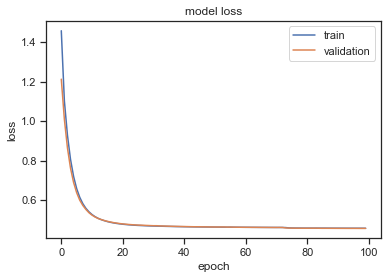

In [32]:
#Visualizing the Loss over epochs
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [19]:
#Obtain the reduced data
encoder = Model(inputs = input_dim_list, outputs = encoded3)
encoded_input = Input(shape = (encoding_dim, ))

encoded_train = pd.DataFrame(encoder.predict(pancancer_meth_list), index=pancancer_meth_list[0].index) #Maintain Index for Mapping to cancer type 
encoded_train = encoded_train.add_prefix('feature_')
encoded_train.shape

(9756, 100)

In [20]:
#output dataset
shape_before_removing_nan = encoded_train.shape
encoded_train.replace(0, np.nan, inplace=True) #Converting all the zero's to nan to use nan command
encoded_train.dropna(how='all',axis=1, inplace=True) #Removing columns with all nan rows
encoded_train.dropna(how='all',axis=0, inplace=True) #Removing rows with all nan columns
encoded_train.replace(np.nan, 0, inplace=True) #Converting all the nan's to zero to be compatible with t-SNE
print(shape_before_removing_nan, encoded_train.shape)

encoded_train.to_csv("Meth_AE_v2.csv", index=True)
# encoded_train = pd.read_csv("Meth_AE_v2.csv",index_col=[0,1,2,3,4])

(9756, 100) (9756, 29)


In [21]:
#Scaling these features to -1,1 range for applying tsne
from sklearn.preprocessing import MinMaxScaler
feature_list = encoded_train.columns.tolist()
scaler = MinMaxScaler(feature_range=(0,1))
encoded_train[feature_list] = scaler.fit_transform(encoded_train[feature_list])

In [45]:
encoded_train = pd.read_csv("Meth_AE_v2.csv",index_col=[0,1,2,3,4])

In [46]:
encoded_train.head()

,,,,,feature_2,feature_3,feature_12,feature_19,feature_25,feature_28,feature_30,feature_31,feature_33,feature_38,...,feature_64,feature_67,feature_70,feature_76,feature_78,feature_80,feature_90,feature_93,feature_95,feature_98
patient,sample,sample_type,aliquot,file,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J4,TCGA-OR-A5J4-01A,01A,TCGA-OR-A5J4-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0874f4b8-5743-4b41-9b99-f02186c8b51e\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J4-01A-11D-A29J-05.gdc_hg38_betaonly.txt,17.592880,0.0,12.178321,5.321238,0.0,17.502638,17.004120,25.415170,73.671800,8.919367,...,14.635925,31.115517,0.000000,0.0,7.533902,12.709701,35.561604,5.514411,14.582859,0.0
TCGA-OR-A5KO,TCGA-OR-A5KO-01A,01A,TCGA-OR-A5KO-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0885b557-48ca-4865-b17a-f2e1f6209b81\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5KO-01A-11D-A29J-05.gdc_hg38_betaonly.txt,15.668279,0.0,9.361001,9.895276,0.0,9.172105,3.608057,37.005516,111.455870,10.292023,...,10.467438,12.468121,5.246295,0.0,7.060614,23.523785,31.606932,14.920638,15.025937,0.0
TCGA-OR-A5J9,TCGA-OR-A5J9-01A,01A,TCGA-OR-A5J9-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\09eb5b05-2794-437b-a307-5255f69c4a32\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J9-01A-11D-A29J-05.gdc_hg38_betaonly.txt,38.195830,0.0,8.865343,7.899178,0.0,0.584159,0.000000,55.528366,168.797930,12.164724,...,0.000000,0.000000,17.751690,0.0,0.000000,45.960537,19.199965,4.259454,10.700577,0.0
TCGA-OR-A5K6,TCGA-OR-A5K6-01A,01A,TCGA-OR-A5K6-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\10ee4988-4a8f-4a0e-ae63-cc891c765fba\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5K6-01A-11D-A29J-05.gdc_hg38_betaonly.txt,13.692106,0.0,10.730237,10.933248,0.0,14.404623,0.433956,27.324120,107.863754,8.188733,...,12.975466,15.026420,4.424022,0.0,8.340714,20.630566,14.628905,4.340840,18.508379,0.0
TCGA-OR-A5JJ,TCGA-OR-A5JJ-01A,01A,TCGA-OR-A5JJ-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\16ff6c63-eca7-4376-a13e-682682b74e11\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5JJ-01A-11D-A29J-05.gdc_hg38_betaonly.txt,20.739574,0.0,4.633999,3.792340,0.0,11.916479,0.000000,44.292526,130.142170,11.494758,...,6.985311,0.448434,10.099040,0.0,5.725468,26.011442,26.448368,4.235372,20.296267,0.0


### 6. Dimension Reduction and Cluster Visualization using t-SNE 


perplexity parameter can be changed based on the input datatset - dataset with larger number of variables requires larger perplexity set this value between 5 and 50 (sklearn documentation) verbose=1 displays run time messages set n_iter sufficiently high to resolve the well stabilized cluster get embeddings


In [47]:
# Perform t-SNE on AE encoded_features
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=40, learning_rate=300, n_iter=400, verbose=1)
#TSNE(n_components=2, perplexity=105, n_iter=1000, verbose=1).fit_transform(encoded_train)
tsne_out = tsne.fit_transform(encoded_train)
tsne_components = pd.DataFrame(tsne_out, index =encoded_train.index ) #Maintain Index


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9756 samples in 0.000s...
[t-SNE] Computed neighbors for 9756 samples in 3.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9756
[t-SNE] Computed conditional probabilities for sample 2000 / 9756
[t-SNE] Computed conditional probabilities for sample 3000 / 9756
[t-SNE] Computed conditional probabilities for sample 4000 / 9756
[t-SNE] Computed conditional probabilities for sample 5000 / 9756
[t-SNE] Computed conditional probabilities for sample 6000 / 9756
[t-SNE] Computed conditional probabilities for sample 7000 / 9756
[t-SNE] Computed conditional probabilities for sample 8000 / 9756
[t-SNE] Computed conditional probabilities for sample 9000 / 9756
[t-SNE] Computed conditional probabilities for sample 9756 / 9756
[t-SNE] Mean sigma: 5.363240


C:\Users\ssrikrishnan6\Anaconda3\envs\metalearning\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.300728
[t-SNE] KL divergence after 400 iterations: 1.952060


In [48]:
tsne_components = pd.DataFrame(tsne_out, index =encoded_train.index ) #Maintain Index
tsne_components.head()

,,,,,0,1
patient,sample,sample_type,aliquot,file,,
TCGA-OR-A5J4,TCGA-OR-A5J4-01A,01A,TCGA-OR-A5J4-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0874f4b8-5743-4b41-9b99-f02186c8b51e\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J4-01A-11D-A29J-05.gdc_hg38_betaonly.txt,-14.754294,10.418760
TCGA-OR-A5KO,TCGA-OR-A5KO-01A,01A,TCGA-OR-A5KO-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0885b557-48ca-4865-b17a-f2e1f6209b81\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5KO-01A-11D-A29J-05.gdc_hg38_betaonly.txt,33.952446,8.329447
TCGA-OR-A5J9,TCGA-OR-A5J9-01A,01A,TCGA-OR-A5J9-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\09eb5b05-2794-437b-a307-5255f69c4a32\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J9-01A-11D-A29J-05.gdc_hg38_betaonly.txt,142.703568,3.923289
TCGA-OR-A5K6,TCGA-OR-A5K6-01A,01A,TCGA-OR-A5K6-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\10ee4988-4a8f-4a0e-ae63-cc891c765fba\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5K6-01A-11D-A29J-05.gdc_hg38_betaonly.txt,19.066032,2.495233
TCGA-OR-A5JJ,TCGA-OR-A5JJ-01A,01A,TCGA-OR-A5JJ-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\16ff6c63-eca7-4376-a13e-682682b74e11\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5JJ-01A-11D-A29J-05.gdc_hg38_betaonly.txt,60.753765,2.808640


### 7. Mapping samples to cancer type


In [49]:
import pandas as pd
patient_metadata = pd.read_csv(r"C:\Users\ssrikrishnan6\ae_integration\info_all_ex.txt", sep = "\t")
patient_metadata = patient_metadata[[ 'cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id','cases.0.project.project_id','cases.0.samples.0.sample_type']] #tolist()
patient_metadata.rename(columns={'cases.0.project.project_id': "cancer_type", "cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id":"tcga_id"},inplace=True)
patient_metadata.set_index("tcga_id", inplace=True)

new_patient_indices = []
for index in patient_metadata.index:
    new_patient_indices.append("-".join(index.split("-")[:-3]))
patient_metadata.index = new_patient_indices

In [50]:
#Parsing the index to extract TCGA Barcode
new_indices = []
for index in tsne_components.index:
    new_indices.append(index[1])

new_tsne_components = tsne_components.copy()
new_tsne_components.index = new_indices

#Merging based on tcga_id
grouped_tsne = pd.merge(new_tsne_components , patient_metadata['cancer_type'] , left_index=True, right_index=True)

grouped_tsne.head()
grouped_tsne.to_csv("tsne_meth_ae_v2.csv")

In [51]:
# grouped_tsne = pd.merge(new_tsne_components , patient_metadata['cancer_type'], left_index=True, right_index=True)
grouped_tsne.shape

(9151, 3)

In [52]:
temp_list = list(set(new_tsne_components.index.tolist()) - set(patient_metadata['cancer_type'].index.tolist()))
len(temp_list)

655

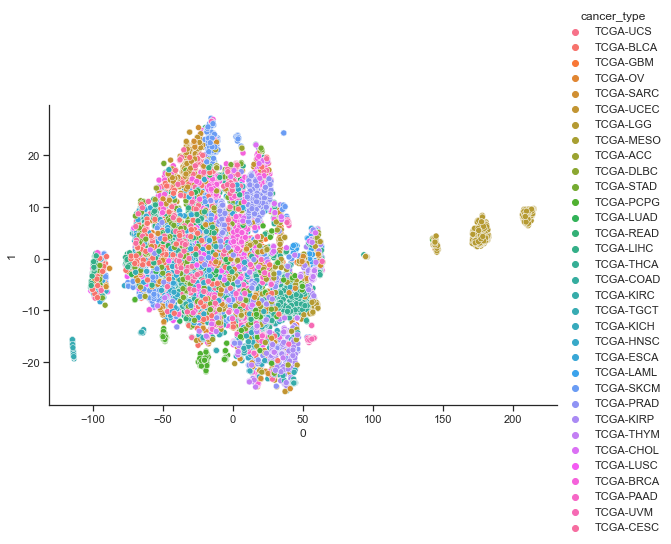

In [53]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='ticks')

cancer_types = grouped_tsne['cancer_type'].tolist()
cancer_types = list(set(cancer_types))

seaborn.relplot(data=grouped_tsne, x=0, y=1, hue='cancer_type', hue_order=cancer_types, aspect=1.61)
plt.show()

Relplot = A figure-level function for visualizing statistical relationships using two common approaches: scatter plots and line plots. relplot() combines a FacetGrid with one of two axes-level functions: scatterplot() (with kind="scatter" ; the default)

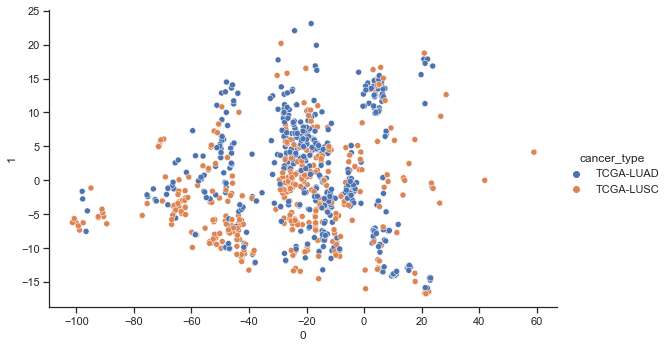

In [54]:
lung_cancer_types = ["TCGA-LUAD","TCGA-LUSC"] 
lung_cancer_df = grouped_tsne[grouped_tsne['cancer_type'].isin(lung_cancer_types)]

seaborn.relplot(data=lung_cancer_df, x=0, y=1, hue='cancer_type', hue_order=lung_cancer_types, aspect=1.61)
plt.show()

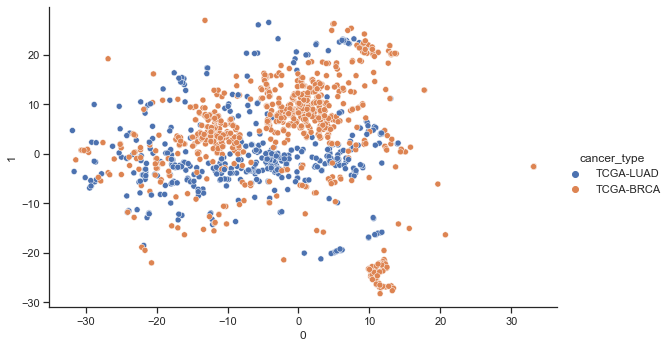

In [31]:
lung_breast_cancer_types = ["TCGA-LUAD","TCGA-BRCA"] 
lung_breast_cancer_df = grouped_tsne[grouped_tsne['cancer_type'].isin(lung_breast_cancer_types)]

seaborn.relplot(data=lung_breast_cancer_df, x=0, y=1, hue='cancer_type', hue_order=lung_breast_cancer_types, aspect=1.61)
plt.show()

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
import os
print (os.environ['CONDA_DEFAULT_ENV'])

tf_gpu


In [8]:
def plot_latent(z, anno, save = None, figsize = (10,10), axis_label = "Latent", **kwargs):
    _kwargs = {
        "s": 10,
        "alpha": 0.9,
    }
    _kwargs.update(kwargs)

    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()
    cluster_types = set([x for x in np.unique(anno)])
    colormap = plt.cm.get_cmap("tab20", len(cluster_types))

    for i, cluster_type in enumerate(cluster_types):
        index = np.where(anno == cluster_type)[0]
        ax.scatter(z[index,0], z[index,1], color = colormap(i), label = cluster_type, **_kwargs)
    
    ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1))
    
    ax.tick_params(axis = "both", which = "major", labelsize = 15)

    ax.set_xlabel(axis_label + " 1", fontsize = 19)
    ax.set_ylabel(axis_label + " 2", fontsize = 19)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    if save:
        fig.savefig(save, bbox_inches = "tight")
    
    print(save)


# plot_latent(ae_coordinates, anno_ctrl, axis_label = "Latent", save = "AE.pdf")

In [7]:
 !pip3 show tensorflow

Name: tensorflow
Version: 2.8.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\ssrikrishnan6\anaconda3\lib\site-packages
Requires: libclang, six, h5py, keras-preprocessing, termcolor, google-pasta, opt-einsum, tensorboard, gast, astunparse, flatbuffers, tf-estimator-nightly, tensorflow-io-gcs-filesystem, grpcio, protobuf, typing-extensions, absl-py, setuptools, wrapt, numpy, keras
Required-by: 


In [ ]:
import tf-night